In [1]:
import pandas as pd
import numpy as np
import os

import pandas as pd
import numpy as np
from collections import Counter
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import math
from sklearn.preprocessing import MinMaxScaler
import scipy
from sklearn import metrics

import numpy as np
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr

import seaborn as sns
import matplotlib.pyplot as plt
import shap

from tqdm.notebook import tqdm

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from scipy.stats import linregress
from scipy import stats


In [2]:
BAGs_data_subsample = pd.read_excel('data/BAGs_data_subsample.xlsx')


linewidths is ignored by contourf
linewidths is ignored by contourf
linewidths is ignored by contourf


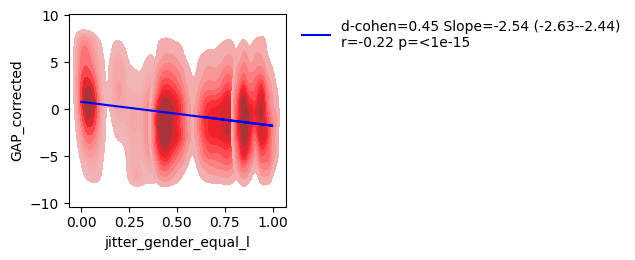

In [4]:
from sklearn.neighbors import NearestNeighbors


df = BAGs_data_subsample.copy()

Q1 = df['GAP_corrected'].quantile(0.25)
Q3 = df['GAP_corrected'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.0 * IQR
upper_bound = Q3 + 1.0 * IQR

from scipy import stats

df['z_score'] = stats.zscore(df['GAP_corrected'])

outliers = df[(df['GAP_corrected'] < lower_bound) | (BAGs_data_subsample['GAP_corrected'] > upper_bound)]
outliers2 = df[(df['z_score'] > 3) | (df['z_score'] < -3)]


df = df[(df['GAP_corrected'] >= lower_bound) & (df['GAP_corrected'] <= upper_bound)]


df.reset_index(inplace = True, drop = True)

vars_physical = ['gender_equal_l', 'Migration', 'Polution_conc_inv', 'Eq']

vars_extended = ['free_parties_l',  'inclu_suff_est', 'cred_elect_est', 'local_dem_est']

scaler = MinMaxScaler()
df[vars_physical] = scaler.fit_transform(df[vars_physical])
df['physical'] = df[vars_physical].mean(axis=1)

df[vars_extended] = scaler.fit_transform(df[vars_extended])
df['extended'] = df[vars_extended].mean(axis=1)

total_exposomes = vars_physical + vars_extended
df[total_exposomes] = scaler.fit_transform(df[total_exposomes])
df['total_exposomes'] = df[total_exposomes].mean(axis=1)

expos_ = ['gender_equal_l', 'Migration', 'Polution_conc_inv', 'Eq', 'representation_l', 'free_parties_l', 'inclu_suff_est', 'cred_elect_est', 'local_dem_est', 'physical', 'extended', 'total_exposomes']


for exp in expos_[0:1]:
    plt.figure(figsize=(2.8,2.5))

    df_exp = df.copy()

    df_exp.dropna(inplace = True)
    df_exp.reset_index(inplace = True, drop = True)
    
    
    colores = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'gray']
    
    df_exp['jitter_' + exp] = np.maximum(0, df_exp[exp] + np.random.uniform(-0.03, 0.03, size=len(df_exp)))
    
    colores = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'gray']
    colores_dict={}
    colores_dict['total_exposomes'] = 'gray'
    colores_dict['extended'] = '#3A549A'
    colores_dict['physical'] = '#5B1530'
    colores_dict['gender_equal_l'] = '#FEB4B5'
    colores_dict['Migration'] = '#FE7E80'
    colores_dict['Polution_conc_inv'] = '#D00000'
    colores_dict['Eq'] = '#8A0000'
    colores_dict['representation_l'] = '#A3E3E6'
    colores_dict['free_parties_l'] = '#5CA7A6'
    colores_dict['inclu_suff_est'] = '#3AE0D3'
    colores_dict['cred_elect_est'] = '#0CFEF9'
    colores_dict['local_dem_est'] = '#7AFFDC'

    sns.kdeplot(
        data=df_exp[(df_exp[exp] >= 0) & (df_exp[exp] <= 0.4)],
        x= 'jitter_' + exp,
        y='GAP_corrected',
        color = colores_dict[exp], label= exp,
        levels=10,
        alpha=1.0,
        fill=True,
        linewidths=1.5
        
    )


    sns.kdeplot(
        data=df_exp[(df_exp[exp] > 0.4) & (df_exp[exp] <= 0.8)],
        x= 'jitter_' + exp,
        y='GAP_corrected',
        color = colores_dict[exp], label= exp,
        levels=10,
        alpha=1.0,
        fill=True,
        linewidths=1.5
        
    )

    sns.kdeplot(
        data=df_exp[(df_exp[exp] > 0.8) & (df_exp[exp] <= 1)],
        x= 'jitter_' + exp,
        y='GAP_corrected',
        color = colores_dict[exp], label= exp,
        levels=10,
        alpha=1.0,
        fill=True,
        linewidths=1.5
        
    )
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_exp[exp], df_exp['GAP_corrected'])
    confidence_interval = 2.58 * std_err
    slope_ci_lower = slope - confidence_interval
    slope_ci_upper = slope + confidence_interval


   
    if(p_value<1e-15):
        p_value = '<1e-15'


    r_value1 = np.abs(r_value)
    d_cohen = (2 * r_value1) / np.sqrt(1 - r_value1**2)

    plt.plot(df_exp[exp], intercept + slope * df_exp[exp], color=colores[0], label = f'd-cohen={d_cohen:.2f} Slope={slope:.2f} ({slope_ci_lower:.2f}-{slope_ci_upper:.2f})\nr={r_value:.2f} p={p_value}')

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., frameon=False);
    

## Exclude low density zones

In [5]:
BAGs_data = pd.read_excel('data/BAGs_data.xlsx')
BAGs_data

,Unnamed: 0,GAP_corrected,gender_equal_l,Migration,Polution_conc_inv,Eq,representation_l,free_parties_l,inclu_suff_est,cred_elect_est,local_dem_est
0,0,3.629656,0.460079,0.064917,24.843759,57.6,-0.039160,0.028814,0.000000,0.00000,0.007719
1,1,8.964122,0.460079,0.064917,24.843759,57.6,-0.039160,0.028814,0.000000,0.00000,0.007719
2,2,5.098340,0.460079,0.064917,24.843759,57.6,-0.039160,0.028814,0.000000,0.00000,0.007719
3,3,-3.082396,0.460079,0.064917,24.843759,57.6,-0.039160,0.028814,0.000000,0.00000,0.007719
4,4,5.587158,0.460079,0.064917,24.843759,57.6,-0.039160,0.028814,0.000000,0.00000,0.007719
...,...,...,...,...,...,...,...,...,...,...,...
161976,161976,-0.240089,0.724532,8.529390,65.074136,50.7,0.824041,0.679014,0.951361,0.88219,0.935729
161977,161977,4.384484,0.724532,8.529390,65.074136,50.7,0.824041,0.679014,0.951361,0.88219,0.935729
161978,161978,4.027009,0.724532,8.529390,65.074136,50.7,0.824041,0.679014,0.951361,0.88219,0.935729
161979,161979,-6.396625,0.724532,8.529390,65.074136,50.7,0.824041,0.679014,0.951361,0.88219,0.935729


linewidths is ignored by contourf


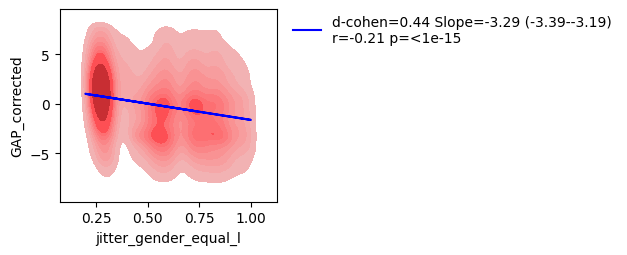

In [8]:
from sklearn.neighbors import NearestNeighbors


df = BAGs_data.copy()



Q1 = df['GAP_corrected'].quantile(0.25)
Q3 = df['GAP_corrected'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.0 * IQR
upper_bound = Q3 + 1.0 * IQR

from scipy import stats

df['z_score'] = stats.zscore(df['GAP_corrected'])

outliers = df[(df['GAP_corrected'] < lower_bound) | (BAGs_data['GAP_corrected'] > upper_bound)]
outliers2 = df[(df['z_score'] > 3) | (df['z_score'] < -3)]


df = df[(df['GAP_corrected'] >= lower_bound) & (df['GAP_corrected'] <= upper_bound)]


df.reset_index(inplace = True, drop = True)



vars_physical = ['gender_equal_l', 'Migration', 'Polution_conc_inv', 'Eq']

vars_extended = ['free_parties_l',  'inclu_suff_est', 'cred_elect_est', 'local_dem_est']

scaler = MinMaxScaler()
df[vars_physical] = scaler.fit_transform(df[vars_physical])
df['physical'] = df[vars_physical].mean(axis=1)

df[vars_extended] = scaler.fit_transform(df[vars_extended])
df['extended'] = df[vars_extended].mean(axis=1)

total_exposomes = vars_physical + vars_extended
df[total_exposomes] = scaler.fit_transform(df[total_exposomes])
df['total_exposomes'] = df[total_exposomes].mean(axis=1)

expos_ = ['gender_equal_l', 'Migration', 'Polution_conc_inv', 'Eq', 'representation_l', 'free_parties_l', 'inclu_suff_est', 'cred_elect_est', 'local_dem_est', 'physical', 'extended', 'total_exposomes']


limits_dict={}
limits_dict['total_exposomes'] = 0.5
limits_dict['extended'] = 0.50
limits_dict['physical'] = 0.15
limits_dict['gender_equal_l'] = 0.15
limits_dict['Migration'] = 0.5
limits_dict['Polution_conc_inv'] = 0.5
limits_dict['Eq'] = 0.25
limits_dict['representation_l'] = 0.5
limits_dict['free_parties_l'] = 0.5
limits_dict['inclu_suff_est'] = 0.5
limits_dict['cred_elect_est'] = 0.5
limits_dict['local_dem_est'] = 0.5

for exp in expos_[0:1]:
    plt.figure(figsize=(2.8,2.5))

    df_exp = df.copy()

    if(exp == 'Migration'):
        df_exp = df_exp[df_exp[exp] < limits_dict[exp]]
    else:
        df_exp = df_exp[df_exp[exp] > limits_dict[exp]]
    

    df_exp.dropna(inplace = True)
    df_exp.reset_index(inplace = True, drop = True)
    

    
    colores = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'gray']
    
    df_exp['jitter_' + exp] = np.maximum(0, df_exp[exp] + np.random.uniform(-0.03, 0.03, size=len(df_exp)))
    
    colores = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'gray']
    colores_dict={}
    colores_dict['total_exposomes'] = 'gray'
    colores_dict['extended'] = '#3A549A'
    colores_dict['physical'] = '#5B1530'
    colores_dict['gender_equal_l'] = '#FEB4B5'
    colores_dict['Migration'] = '#FE7E80'
    colores_dict['Polution_conc_inv'] = '#D00000'
    colores_dict['Eq'] = '#8A0000'
    colores_dict['representation_l'] = '#A3E3E6'
    colores_dict['free_parties_l'] = '#5CA7A6'
    colores_dict['inclu_suff_est'] = '#3AE0D3'
    colores_dict['cred_elect_est'] = '#0CFEF9'
    colores_dict['local_dem_est'] = '#7AFFDC'

    sns.kdeplot(
        data=df_exp,
        x= 'jitter_' + exp,
        y='GAP_corrected',
        color = colores_dict[exp], label=exp,
        levels=10,
        alpha=1.0,
        fill=True,
        linewidths=1.5
        
    )


    slope, intercept, r_value, p_value, std_err = stats.linregress(df_exp[exp], df_exp['GAP_corrected'])
    confidence_interval = 2.58 * std_err  # 95% CI: slope ± 1.96 * std_err
    slope_ci_lower = slope - confidence_interval
    slope_ci_upper = slope + confidence_interval


    if(p_value<1e-15):
        p_value = '<1e-15'


    r_value1 = np.abs(r_value)
    d_cohen = (2 * r_value1) / np.sqrt(1 - r_value1**2)

    plt.plot(df_exp[exp], intercept + slope * df_exp[exp], color=colores[0], label = f'd-cohen={d_cohen:.2f} Slope={slope:.2f} ({slope_ci_lower:.2f}-{slope_ci_upper:.2f})\nr={r_value:.2f} p={p_value}')

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., frameon=False);
    